# Week 8: Generative Models

Welcome to this Week 8 hands-on tutorial! In this notebook, we’ll explore how to train Variational Autoencoders (VAEs) and Generative Adversarial Networks (GANs) using **PyTorch**. These models are powerful tools for generating new data samples and learning complex data distributions.

For this task, we will build and train both a **VAE** and a **GAN**:

- **Variational Autoencoder (VAE)**: A probabilistic model that represents input data in a latent space by learning both reconstruction and a prior distribution, useful for generative modeling.  
  - **Encoder**: Maps input data to the parameters (mean and variance) of a latent probability distribution.  
  - **Decoder**: Reconstructs data from samples drawn from the latent distribution.  
  - **Latent Space**: A probabilistic representation of the data distribution that allows for structured sampling and interpolation.  


- **Generative Adversarial Network (GAN)**: Consists of two neural networks, a generator and a discriminator, that compete against each other. The generator creates fake data samples, while the discriminator tries to distinguish between real and fake samples.
  - **Generator**: Generates new data samples from random noise.
  - **Discriminator**: Classifies data samples as real or fake.
  - **Adversarial Training**: The generator and discriminator are trained simultaneously, improving each other’s performance.

By the end of this notebook, you’ll understand how to:
1. Preprocess data for training VAEs and GANs.
2. Build and train a VAE using PyTorch.
3. Build and train a GAN using PyTorch.
4. Generate new data samples.

Let’s dive in and start building!

## Variational Autoncoder

### Step 1: Import libraries and load the MNIST dataset

In this step, we’ll prepare our tools and data to kickstart the project. First, we’ll import the necessary libraries that make it possible to handle data, build and train neural networks, and visualize results effectively. 

Next, we’ll load the **MNIST dataset** using `torchvision`. As a quick refresher, the MNIST dataset contains 70,000 grayscale images (28x28 pixels) of handwritten digits, distributed across 10 classes (digits 0 through 9). Each class has a varying number of images, providing a diverse dataset for training.

To reduce computational requirements, we’ll **resize** the images and **flatten** them. Resizing adjusts the dimensions of the images, and flattening converts the 2D images into 1D vectors, making it easier for the model to process and speeding up the training process.

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

c:\Users\20236095\disconet\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


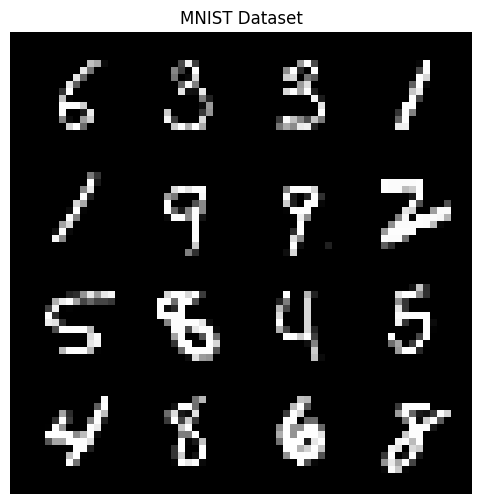

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((14, 14), interpolation=0),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.MNIST(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=128,
    shuffle=True, 
    num_workers=0
)


def plot_dataset(X, **kwargs):
    '''
    Plot a 2D dataset.
    Args:
        X: torch.Tensor: The images to plot.
        **kwargs: dict: Additional keyword arguments to pass to `ax.set`.
    '''
    # reshape the data to 14x14 images
    X = X.view(-1, 14, 14)
    # get 16 samples from the batch
    X = X[:16].unsqueeze(1)
    # make a grid of the images
    grid = make_grid(X, nrow=4, normalize=True)
    # plot the image grid
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')
    if kwargs.get('title', None):
        plt.title(kwargs.get('title', ''))
    plt.show()


# Plot images from the dataset
X, _ = next(iter(train_dataloader))
fig = plt.figure(figsize=(6, 6))
plot_dataset(X, title='MNIST Dataset')

### Step 2: Building the VAE Components

In this step, we will build and implement the core components of a Variational Autoencoder (VAE): the encoder, the decoder, and the reparametrization trick.

#### Encoder
The encoder compresses the input data into a latent representation. It consists of several layers that reduce the dimensionality of the input data.

#### Decoder
The decoder reconstructs the data from the latent representation. It consists of several layers that expand the latent representation back to the original data dimensions.

#### Reparametrization Trick
The reparametrization trick allows us to sample from the latent space distribution using the mean and log variance estimated from the features extracted by the encoder. This trick ensures that the gradient can flow through the sampling process during backpropagation.

The reparametrization trick is defined as:
$$ z = \mu + \sigma \cdot \epsilon $$
where:
- $ \mu $ is the mean estimated by the encoder.
- $ \sigma $ is the standard deviation, computed as $ \sigma = \exp(\frac{1}{2} \cdot \text{logvar}) $.
- $ \epsilon $ is a random noise vector sampled from a standard normal distribution.

In [5]:
class Block(nn.Module):
    def __init__(self, in_features, out_features, normalize=False):
        '''
        Create a block of an MLP.
        Args:
            in_features: int: The number of input features.
            out_features: int: The number of output features.
            normalize: bool: Whether to apply batch normalization.
        '''
        super().__init__()
        layers = [nn.Linear(in_features, out_features)]
        if normalize:
            layers.append(nn.BatchNorm1d(out_features, 0.8))
        layers.append(nn.ReLU(inplace=True))
        self.block = nn.Sequential(*layers)

    def forward(self, X):
        '''
        Forward pass of the model.
        Args:
            X: torch.Tensor: The input features.
        Returns:
            torch.Tensor: The output features.
        '''
        return self.block(X)

class Encoder(nn.Module):
    def __init__(self, image_size=14):
        '''
        Create an MLP to generate samples from a latent space.
        Args:
            image_size: int: The size of the images.
        '''
        super().__init__()

        
        self.model = nn.Sequential(
            Block(image_size*image_size, 32, normalize=False),
            Block(32, 64),
            Block(64, 128),
        )


    def forward(self, X):
        '''
        Forward pass of the model.
        Args:
            X: torch.Tensor: The input features.
        Returns:
            torch.Tensor: The encoded features.
        '''
        X = self.model(X)
        return X
    
class Decoder(nn.Module):
    def __init__(self, image_size=14, latent_dim=16):
        '''
        Create an MLP to generate samples from a latent space.
        Args:
            image_size: int: The size of the images.
            latent_dim: int: The dimensionality of the latent space.
        '''
        super().__init__()

        self.model = nn.Sequential(
            Block(latent_dim, 128),
            Block(128, 64),
            Block(64, 32),
            nn.Linear(32, image_size*image_size),
            nn.Tanh()
        )

    def forward(self, X):
        '''
        Forward pass of the model.
        Args:
            X: torch.Tensor: The input features.
        Returns:
            torch.Tensor: The generated samples.
        '''
        X = self.model(X)
        return X
    
class VariationalAutoEncoder(nn.Module):
    def __init__(self, image_size=14, latent_dim=8):
        '''
        Create a VAE.
        Args:
            image_size: int: The size of the images.
            latent_dim: int: The dimensionality of the latent space.
        '''
        super().__init__()
        self.encoder = Encoder(image_size)
        self.mu = nn.Linear(128, latent_dim)
        self.logvar = nn.Linear(128, latent_dim)
        self.decoder = Decoder(image_size, latent_dim)
        self.latent_dim = latent_dim

    def forward(self, X):
        '''
        Forward pass of the model.
        Args:
            X: torch.Tensor: The input features.
        Returns:
            X: torch.Tensor: The generated samples.
            mu: torch.Tensor: The mean of the latent space.
            logvar: torch.Tensor: The log variance of the latent space.
        '''
        X = self.encoder(X)
        mu = self.mu(X)
        logvar = self.logvar(X)
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        X = mu + eps*std
        X = self.decoder(X)
        return X, mu, logvar

### Step 3: Defining the Loss Functions and Training the VAE

In this step, we will define the loss functions required to train the VAE: the KL divergence loss and the global VAE loss (Evidence Lower Bound, ELBO). We will then train the model using these loss functions.

### KL Divergence
The KL divergence loss measures the difference between the learned latent distribution and a standard normal distribution. It ensures that the latent space follows a normal distribution, which is crucial for generating new data samples.

The KL divergence for a single data point can be determined using
$$ \mathcal{L}_{\text{KL}} = \frac{1}{2} \sum(1 + \text{logvar} - \mu^2 - \exp(\text{logvar})) $$

### Reconstruction Loss
The reconstruction loss measures how well the decoder can reconstruct the input data from the latent representation. It is typically defined as the mean squared error (MSE) or binary cross-entropy (BCE) between the input and the reconstructed output.

### Global VAE Loss (ELBO)
The global VAE loss, also known as the Evidence Lower Bound (ELBO), combines the reconstruction loss and the KL divergence loss. Minimizing the ELBO ensures that the model learns to reconstruct the data accurately while maintaining a well-structured latent space.

The ELBO is defined as
$$ \text{ELBO} = \text{Reconstruction Loss} + \text{KL Divergence Loss} $$

### Training the Model
To train the VAE, we will:
1. Perform a forward pass through the model to obtain the reconstructed image, the mean and the log variance.
2. Compute the reconstruction loss and the KL divergence loss.
3. Combine the losses to compute the ELBO.
4. Perform backpropagation and update the model parameters.

In [8]:
def kl_loss(mu, logvar):
    '''
    Compute the KL divergence loss.
    Args:
        mu: torch.Tensor: The mean of the latent space.
        logvar: torch.Tensor: The log variance of the latent space.
    Returns:
        torch.Tensor: The KL divergence loss.
    '''
    kl_loss = 0.5 * torch.sum(torch.exp(logvar) + mu ** 2 - 1 - logvar, dim = 1)
    return kl_loss.mean()

def vae_loss(X, X_hat, mu, logvar, kl_weight=0.01):
    '''
    Compute the VAE loss.
    Args:
        X: torch.Tensor: The input features.
        X_hat: torch.Tensor: The reconstructed features.
        mu: torch.Tensor: The mean of the latent space.
        logvar: torch.Tensor: The log variance of the latent space.
    Returns:
        torch.Tensor: The VAE loss.
    '''
    return nn.MSELoss()(X, X_hat) + kl_weight*kl_loss(mu, logvar)

def train_vae(vae, dataloader, epochs=10, lr=0.001):
    '''
    Train a VAE.
    Args:
        vae: VariationalAutoEncoder: The VAE to train.
        dataloader: DataLoader: The DataLoader for the dataset.
        epochs: int: The number of epochs to train for.
        lr: float: The learning rate to use.
    '''
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
    for epoch in trange(epochs):
        for X, _ in dataloader:
            optimizer.zero_grad()
            X_hat, mu, logvar = vae(X)
            loss = vae_loss(X, X_hat, mu, logvar, kl_weight=0.01)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Create the VAE and train it.
vae = VariationalAutoEncoder(latent_dim=16)
train_vae(vae, train_dataloader, epochs=10, lr=0.001)

 10%|█         | 1/10 [00:11<01:41, 11.27s/it]

Epoch 1/10, Loss: 0.2642818093299866


 20%|██        | 2/10 [00:22<01:31, 11.47s/it]

Epoch 2/10, Loss: 0.25183552503585815


 30%|███       | 3/10 [00:34<01:21, 11.64s/it]

Epoch 3/10, Loss: 0.25196757912635803


 40%|████      | 4/10 [00:46<01:09, 11.63s/it]

Epoch 4/10, Loss: 0.2419157773256302


 50%|█████     | 5/10 [00:58<00:58, 11.80s/it]

Epoch 5/10, Loss: 0.23961837589740753


 60%|██████    | 6/10 [01:10<00:47, 11.91s/it]

Epoch 6/10, Loss: 0.2388753592967987


 70%|███████   | 7/10 [01:22<00:35, 11.99s/it]

Epoch 7/10, Loss: 0.21600781381130219


 80%|████████  | 8/10 [01:34<00:23, 11.94s/it]

Epoch 8/10, Loss: 0.2224147617816925


 90%|█████████ | 9/10 [01:45<00:11, 11.66s/it]

Epoch 9/10, Loss: 0.21938548982143402


100%|██████████| 10/10 [01:56<00:00, 11.67s/it]

Epoch 10/10, Loss: 0.21723750233650208


### Step 4: Sampling from the VAE

In this step, we will sample new data from the trained VAE model. Sampling involves generating new latent vectors from the learned latent space and passing them through the decoder to produce new data samples.

#### Sampling Process
1. **Generate Latent Vectors**: Sample random vectors from a standard normal distribution. These vectors represent points in the latent space.
2. **Decode Latent Vectors**: Pass the sampled latent vectors through the decoder to generate new data samples.

By following this process, we can generate new data samples that are similar to the training data but not identical, demonstrating the generative capabilities of the VAE.

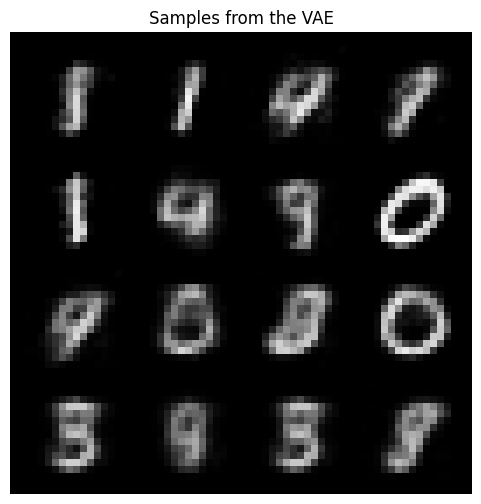

In [9]:
@torch.no_grad()
def sample_vae(vae, n_samples=16):
    '''
    Sample from a VAE.
    Args:
        vae: VariationalAutoEncoder: The VAE to sample from.
        n_samples: int: The number of samples to generate.
    Returns:
        torch.Tensor: The generated samples.
    '''
    vae.eval()
    z = torch.randn(n_samples, vae.latent_dim)
    samples = vae.decoder(z)
    return samples

samples = sample_vae(vae)
fig = plt.figure(figsize=(6, 6))
plot_dataset(samples, title='Samples from the VAE')

## Generative Adversarial Networks

### Step 5: Using a Single Digit for GAN Training

To make the training process of the GAN faster, we will use only one digit from the MNIST dataset. This will reduce the complexity of the data and allow the GAN to focus on generating variations of a single digit.

#### Selecting a Single Digit
We will filter the MNIST dataset to include only images of a specific digit (e.g., digit '0'). This will create a smaller and more focused dataset for training the GAN.

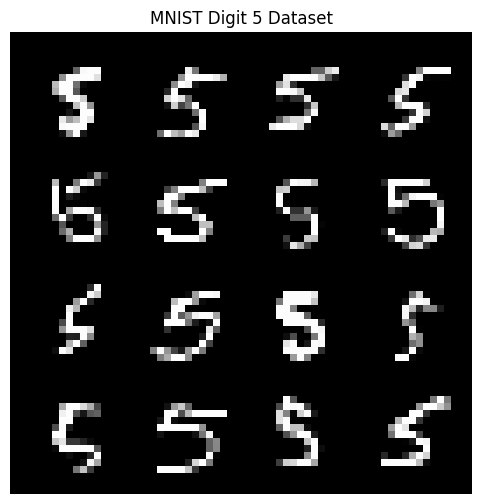

In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((14, 14), interpolation=0),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.MNIST(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)

# lets use ibky the digit 5
train_dataset.data = train_dataset.data[train_dataset.targets == 5]

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=128,
    shuffle=True, 
    num_workers=0
)

# Plot images from the dataset
X, _ = next(iter(train_dataloader))
fig = plt.figure(figsize=(6, 6))
plot_dataset(X, title='MNIST Digit 5 Dataset')

### Step 6: Building the Generator and Discriminator of the GAN

In this step, we will build the generator and discriminator models for the GAN. The generator will create fake data samples from random noise, while the discriminator will classify data samples as real or fake.

#### Generator
The generator takes a random noise vector as input and transforms it into a data sample that resembles the real data. It typically consists of several layers of transposed convolutions or fully connected layers. The final activation function used in the generator is usually a **Tanh** function when the goal is image generation. This activation function scales the output to a range between -1 and 1, which helps in stabilizing the training process and ensuring that the generated data has similar properties to the real data.

#### Discriminator
The discriminator takes a data sample as input and outputs a probability indicating whether the sample is real or fake. It typically consists of several layers of convolutions or fully connected layers. The final activation function used in the discriminator is usually a **Sigmoid** function. This activation function outputs a probability between 0 and 1, which is suitable for binary classification tasks where the goal is to distinguish between real and fake samples.

By defining these models with appropriate final activation functions, we can ensure that the generator produces realistic data samples and the discriminator effectively distinguishes between real and fake samples.

In [24]:
class Block(nn.Module):
    def __init__(self, in_features, out_features, normalize=True):
        '''
        Create a block of an MLP.
        Args:
            in_features: int: The number of input features.
            out_features: int: The number of output features.
            normalize: bool: Whether to apply batch normalization.
        '''
        super().__init__()
        layers = [nn.Linear(in_features, out_features)]
        if normalize:
            layers.append(nn.BatchNorm1d(out_features, 0.8))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.block = nn.Sequential(*layers)

    def forward(self, X):
        '''
        Forward pass of the model.
        Args:
            X: torch.Tensor: The input features.
        Returns:
            torch.Tensor: The output features.
        '''
        return self.block(X)

class Generator(nn.Module):
    def __init__(self, image_size=14, latent_dim=8):
        '''
        Create an MLP to generate samples from a latent space.
        Args:
            image_size: int: The size of the images.
            latent_dim: int: The dimensionality of the latent space.
        '''
        super().__init__()

        
        self.model = nn.Sequential(
            Block(latent_dim, latent_dim*2, normalize=False),
            Block(latent_dim*2, latent_dim*4),
            Block(latent_dim*4, latent_dim*8),
            Block(latent_dim*8, latent_dim*16),
            nn.Linear(latent_dim*16, image_size*image_size),
            nn.Tanh()
        )

        self.latent_dim = latent_dim

    def forward(self, X):
        '''
        Forward pass of the model.
        Args:
            X: torch.Tensor: The input features.
        Returns:
            torch.Tensor: The generated samples.
        '''
        X = self.model(X)
        return X
    
class Discriminator(nn.Module):
    def __init__(self, image_size=14):
        '''
        Create an MLP to discriminate between real and generated samples.
        Args:
            image_size: int: The size of the images.
        '''
        super().__init__()

        self.model = nn.Sequential(
            Block(image_size*image_size, 256, normalize=False),
            Block(256, 128, normalize=False),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, X):
        '''
        Forward pass of the model.
        Args:
            X: torch.Tensor: The input features.
        Returns:
            torch.Tensor: The discriminator's prediction.
        '''
        X = self.model(X)
        return X

### Step 7: Adversarial Loss, Discriminator Loss, and GAN Training

In this step, we will describe the loss functions used to train the GAN and the overall training process.

#### Adversarial Loss
The adversarial loss is used to train the generator. The goal of the generator is to produce data samples that are indistinguishable from real data, thereby "fooling" the discriminator. The adversarial loss for the generator is defined as the negative log probability of the discriminator classifying the generated samples as real:

$$ \mathcal{L}_{\text{G}} = -\log(D(G(z))) $$

where:
- $ G(z) $ is the generated data sample from the generator $ G $ given a random noise vector $ z $.
- $ D $ is the discriminator.

#### Discriminator Loss
The discriminator's goal is to correctly classify real data samples as real and generated data samples as fake. The discriminator loss is a combination of the loss for real samples and the loss for fake samples:

$$ \mathcal{L}_{\text{D}} = -\left[\log(D(x)) + \log(1 - D(G(z)))\right] $$

where:
- $ x $ is a real data sample.
- $ G(z) $ is the generated data sample from the generator $ G $ given a random noise vector $ z $.
- $ D(x) $ is the discriminator's probability that $ x $ is real.
- $ D(G(z)) $ is the discriminator's probability that the generated sample $ G(z) $ is real.

#### GAN Training
The training process for the GAN involves alternating between updating the discriminator and the generator:

1. **Update the Generator**:
   - Sample a batch of random noise vectors $ z $ and generate fake data samples $ G(z) $.
   - Compute the adversarial loss $ \mathcal{L}_{\text{G}} $ for the generator.
   - Perform backpropagation and update the generator's parameters to minimize $ \mathcal{L}_{\text{G}} $.

2. **Update the Discriminator**:
   - Sample a batch of real data samples $ x $ from the dataset.
   - Sample a batch of random noise vectors $ z $ and generate fake data samples $ G(z) $.
   - Compute the discriminator loss $ \mathcal{L}_{\text{D}} $ using both real and fake samples.
   - Perform backpropagation and update the discriminator's parameters to minimize $ \mathcal{L}_{\text{D}} $.

In [30]:
def adversarial_loss(y_hat):
    '''
    Compute the adversarial loss.
    Args:
        y_hat: torch.Tensor: The discriminator's prediction.
    Returns:
        torch.Tensor: The adversarial loss.
    '''
    return nn.BCELoss()(y_hat, torch.ones_like(y_hat))

def discriminator_loss(y_real, y_fake):
    '''
    Compute the discriminator loss.
    Args:
        y_real: torch.Tensor: The discriminator's prediction for real samples.
        y_fake: torch.Tensor: The discriminator's prediction for fake samples.
    Returns:
        torch.Tensor: The discriminator loss.
    '''
    return (nn.BCELoss()(y_real, torch.ones_like(y_real)) + nn.BCELoss()(y_fake, torch.zeros_like(y_fake)))/2

def training_loop(generator, discriminator, dataloader, epochs=10, lr=1e-3):
    '''
    Train a GAN.
    Args:
        generator: Generator: The generator model.
        discriminator: Discriminator: The discriminator model.
        dataloader: DataLoader: The DataLoader for the dataset.
        epochs: int: The number of epochs to train for.
        lr: float: The learning rate to use.
    '''
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
    for epoch in trange(epochs, desc='Epochs'):
        for X, _ in dataloader:

            # Train the generator
            generator_optimizer.zero_grad()
            z = torch.randn(X.size(0), generator.latent_dim)
            X_fake = generator(z)
            y_fake = discriminator(X_fake)
            g_loss = adversarial_loss(y_fake)
            g_loss.backward()
            generator_optimizer.step()

            # Train the discriminator
            discriminator_optimizer.zero_grad()
            y_real = discriminator(X)
            y_fake = discriminator(X_fake.detach())
            d_loss = discriminator_loss(y_real, y_fake)
            d_loss.backward()
            discriminator_optimizer.step()

generator = Generator(latent_dim=16)
discriminator = Discriminator()
training_loop(generator, discriminator, train_dataloader, epochs=100, lr=1e-3)


Epochs: 100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


### Step 8: Sampling from the GAN

In this step, we will sample new data from the trained GAN model. Sampling involves generating new data samples using the generator, which has learned to produce realistic data from random noise vectors.

#### Sampling Process
1. **Generate Random Noise Vectors**: Sample random noise vectors from a standard normal distribution. These vectors serve as the input to the generator.
2. **Generate Data Samples**: Pass the random noise vectors through the generator to produce new data samples.

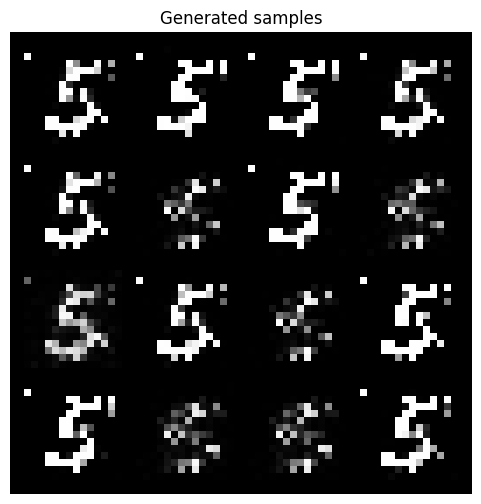

In [43]:
@torch.no_grad()
def sample(generator, n_samples):
    '''
    Sample from the generator.
    Args:
        generator: nn.Module: The generator model.
        n_samples: int: The number of samples to generate.
    '''
    generator.eval()
    noise = torch.randn(n_samples, generator.latent_dim)
    generated = generator(noise)
    return generated

# Sample from the generator and plot the results.
fig = plt.figure(figsize=(6, 6))
samples = sample(generator, n_samples=24)
plot_dataset(samples, title='Generated samples')